In [1]:
import numpy as np
from copy import deepcopy

from plotstyle import init_style, COLORS
init_style()

from qspectro2d.config import SCRIPTS_DIR

from qspectro2d.spectroscopy import compute_2d_fft_wavenumber
from qspectro2d.visualization import plot_example_evo, plot_2d_el_field
from qspectro2d.spectroscopy.one_d_field import compute_polarization_over_window, slice_states_to_window, compute_evolution, sim_with_only_pulses, phase_cycle_component
from qspectro2d.utils.units_and_rwa import from_rotating_frame_list
from qspectro2d.utils.units_and_rwa import from_rotating_frame_list, get_expect_vals_with_RWA

from qspectro2d.config import create_base_sim_oqs
from qspectro2d.utils.data_io import save_simulation_data


In [2]:
config_path = SCRIPTS_DIR / "config.yaml"
# Build base simulation (applies CLI overrides inside)
sim_oqs, time_cut = create_base_sim_oqs(config_path=str(config_path) if config_path else None)

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)


In [3]:
avg_E_sigs = [np.zeros((len(sim_oqs.t_det), ), dtype=complex)]
metadata = {
    "n_batches": 1,
    "signal_types": sim_oqs.simulation_config.signal_types,
}
abs_data_path = save_simulation_data(
    sim_oqs, metadata, avg_E_sigs, t_det=sim_oqs.t_det
)
abs_data_path
str(abs_data_path)

2025-09-19 15:58:27 | INFO | qspectro2d.utils.data_io:124 | Info saved: C:\Users\leopo\.vscode\master_thesis\data\1d_spectroscopy\N1\f16000cm_mu1.0\ME\RWA\t_dm60.0_t_wait_2.0_dt_0.1\t_coh_30.0_info.pkl


'C:\\Users\\leopo\\.vscode\\master_thesis\\data\\1d_spectroscopy\\N1\\f16000cm_mu1.0\\ME\\RWA\\t_dm60.0_t_wait_2.0_dt_0.1\\t_coh_30.0_data.npz'

pulse_delays: [np.float64(30.0), np.float64(2.0)]
Updated pulse_delays: [np.float64(1.493), np.float64(2.0)]
LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  1: t =   1.49 fs | E₀ = 1.000e-02 | FWHM =  6.0 fs | ω = 16000.00 cm^-1 | ϕ =  0.000 rad | type = gaussian


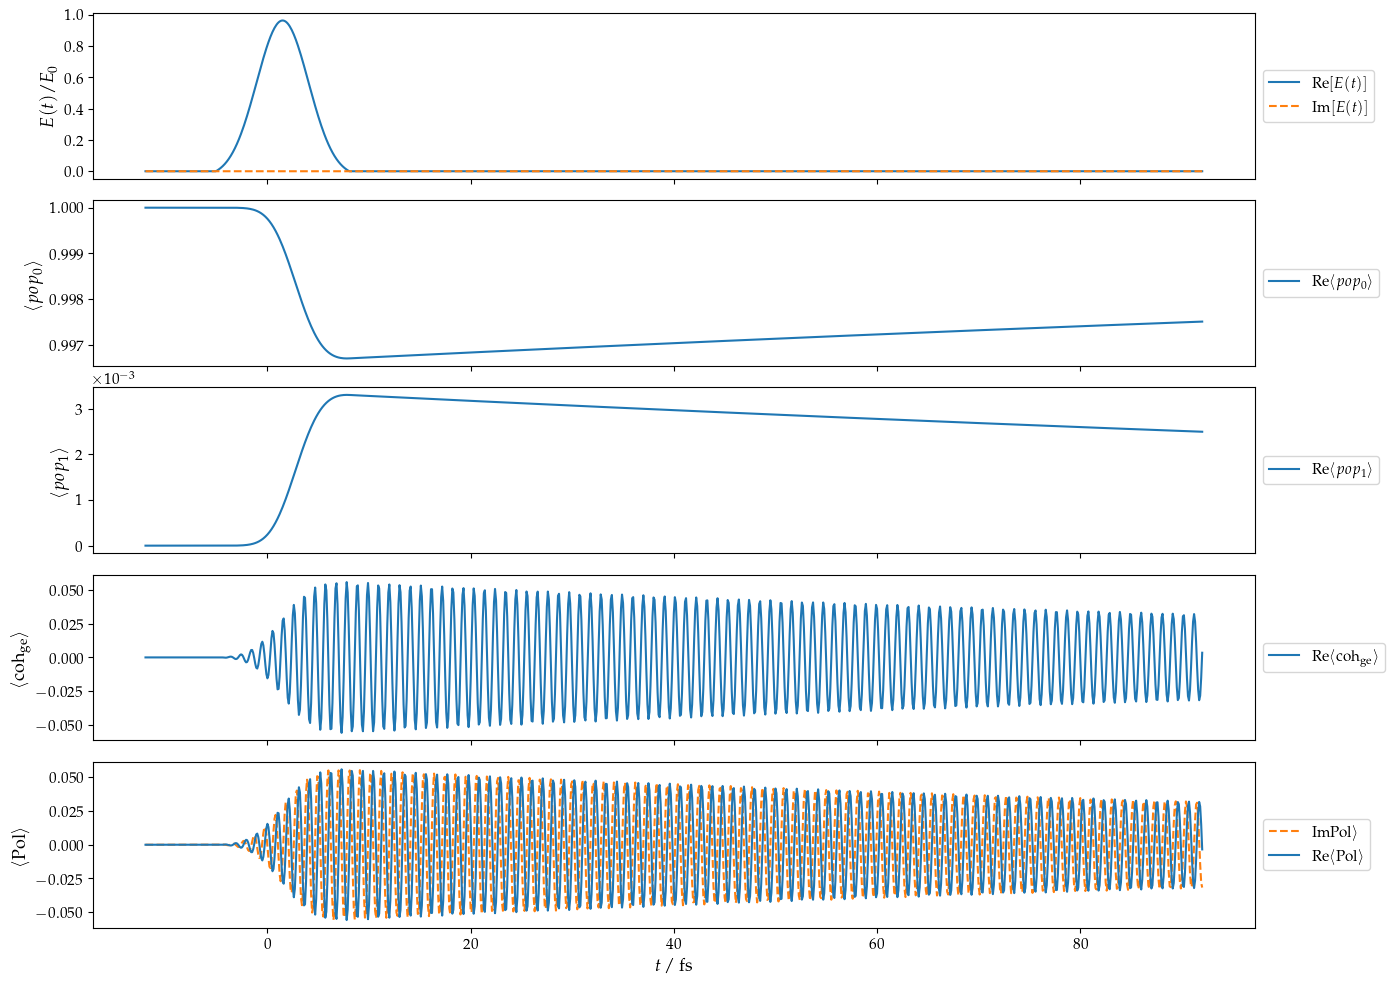

In [4]:
pulse_delays = sim_oqs.laser.pulse_delays
print("pulse_delays:", pulse_delays)
# TODO bigger than this will cause NO evolution!! Why?
pulse_delays[0] = 1.493  # Set first delay to 1.45 for single-pulse simulation
sim_oqs.laser.pulse_delays = pulse_delays
print("Updated pulse_delays:", sim_oqs.laser.pulse_delays)
sim_i = sim_with_only_pulses(sim_oqs, [1])
print(sim_i.laser)
res = compute_evolution(sim_i)
det_states = res.states


times = res.times
rwa_sl = sim_i.simulation_config.rwa_sl
if rwa_sl:
    # States are stored in the rotating frame; convert back to lab for polarization
    det_states = from_rotating_frame_list(
        det_states, times, sim_i.system.n_atoms, sim_i.laser.carrier_freq_fs
    )
expectation_values = get_expect_vals_with_RWA(det_states, 
                                              times - times[0], 
                                              sim_i.system.n_atoms,
                                              sim_i.observable_ops, 
                                              sim_i.laser.carrier_freq_fs,
                                              rwa_sl=rwa_sl,
                                              dipole_op=sim_i.system.dipole_op)

fig_evo = plot_example_evo(times, expectation_values, sim_i.laser, rwa_sl=rwa_sl, observable_strs=sim_i.observable_strs)
display(fig_evo)

# Workflow: `parallel_compute_1d_e_comps`

Super-short stepped visualization added below:
1. Inspect and plot laser pulses (envelope, RWA field, full field).
2. Run several evolutions with different active pulse subsets / modified parameters.
3. Plot expectation values + polarization for multiple detection sub-windows.
4. Build raw phase grid `P_{phi1,phi2}(t)` and extract a phase-cycled component.
5. (Mini 2D) Sweep a few coherence delays `t_coh` to assemble a tiny 2D block and phase-cycle each slice.

Each subsequent cell implements one step.


In [5]:
# Helper functions: polarization + phase-cycling pieces
def build_phase_grid(sim, phases):
    P_grid = []
    t_actual = None
    for phi1 in phases:
        row = []
        for phi2 in phases:
            sim_w = deepcopy(sim)
            sim_w.laser.pulse_phases = [phi1, phi2]
            t_actual, P_phi = compute_polarization_over_window(sim_w, sim_w.t_det_actual)
            row.append(P_phi)
        P_grid.append(row)
    return t_actual, np.array(P_grid)  # shape (n,n,t)
print('Helpers ready.')

Helpers ready.


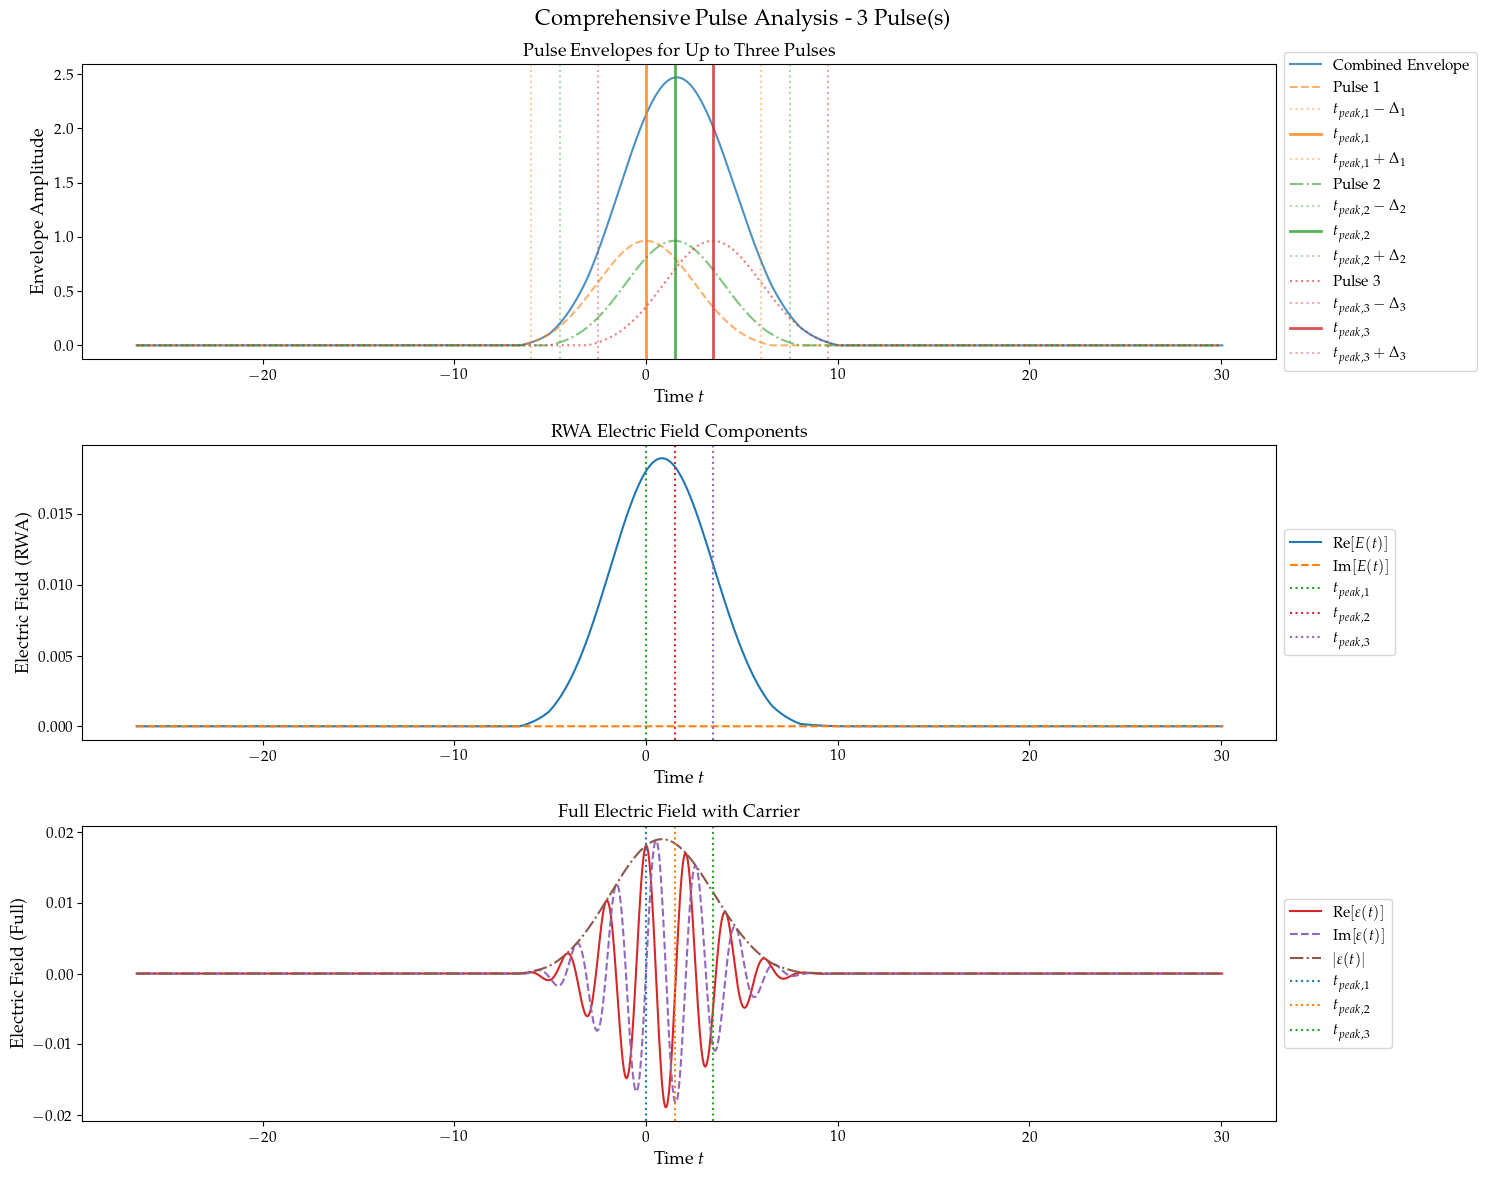

In [6]:
# 1. Laser pulses visualization
from qspectro2d.visualization.plotting import plot_all_pulse_components

pulse_times = np.linspace(sim_oqs.laser.pulses[0].active_time_range[0]-20.0,
                          sim_oqs.laser.pulses[-1].active_time_range[1]+20.0, 1200)
fig_pulses = plot_all_pulse_components(pulse_times, sim_oqs.laser)
fig_pulses

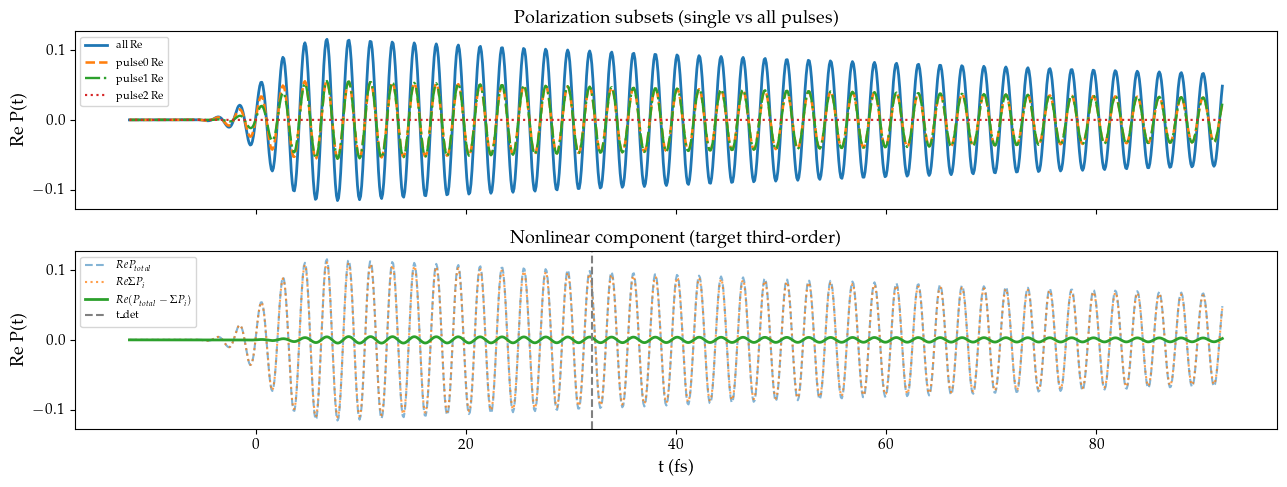

In [7]:
# 2. Evolution subsets: all pulses vs single pulse vs modified amplitude
subset_specs = {
    'all': list(range(len(sim_oqs.laser.pulses))),
}
# Add individual pulses
for i in range(len(sim_oqs.laser.pulses)):
    subset_specs[f'pulse{i}'] = [i]

pol_datas = {}
base_window = sim_oqs.times_local  # detection / plotting window (assumed uniform grid)

for label, idxs in subset_specs.items():
    sim_sub = sim_with_only_pulses(sim_oqs, idxs) if label != 'all' else sim_oqs
    t_actual, P = compute_polarization_over_window(sim_sub, base_window)
    pol_datas[label] = P

# Build nonlinear component: P_total - Σ_i P_i
P_total = pol_datas['all']
linear_sum = np.zeros_like(P_total, dtype=complex)
for i in range(len(sim_oqs.laser.pulses)):
    linear_sum += pol_datas[f'pulse{i}']
pol_nonlinear = P_total - linear_sum  # store for later reuse if needed

# Plotting: two subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(13,5), sharex=True)
ax1, ax2 = axes

# Subplot 1: original subset comparison (real part)
for idx, (k, v) in enumerate(pol_datas.items()):
    ax1.plot(t_actual, np.real(v), color=COLORS[idx % len(COLORS)], linewidth=2-0.15*idx, label=f'{k} Re')
ax1.set_ylabel('Re P(t)')
ax1.set_title('Polarization subsets (single vs all pulses)')
ax1.legend(loc='best', fontsize=8)

# Subplot 2: nonlinear component extraction
ax2.plot(t_actual, np.real(P_total), label='$Re P_{total}$', linestyle='--', color=COLORS[0], alpha=0.55)
ax2.plot(t_actual, np.real(linear_sum), label='$Re \Sigma P_i$', linestyle=':', color=COLORS[1], alpha=0.75)
ax2.plot(t_actual, np.real(pol_nonlinear), label='$Re (P_{total} - \Sigma P_i)$', color=COLORS[2], linewidth=2.0)
# make a vertical line at t_det_actual[0]
ax2.axvline(x=sim_oqs.t_det_actual[0], color='gray', linestyle='--', label='t_det')
ax2.set_ylabel('Re P(t)')
ax2.set_xlabel('t (fs)')
ax2.set_title('Nonlinear component (target third-order)')
ax2.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

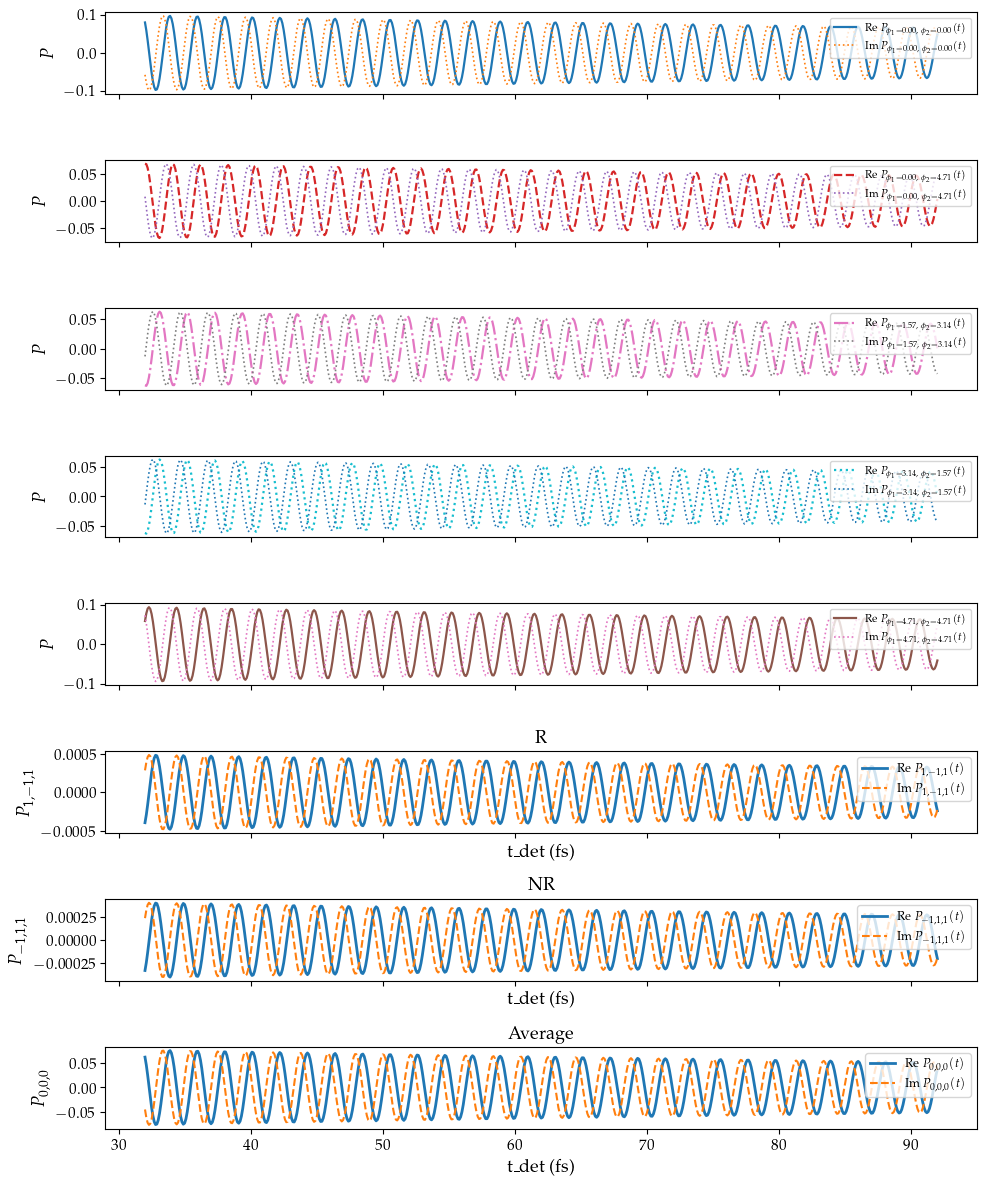

In [8]:
# 4. Phase grid raw vs extracted component (expanded visualization)
from qspectro2d.config.default_simulation_params import PHASE_CYCLING_PHASES, DETECTION_PHASE
phases = PHASE_CYCLING_PHASES[:4]  # small subset for speed

# Build raw grid (n_phi, n_phi, n_t)
t_actual, P_grid = build_phase_grid(sim_oqs, phases)
comp = phase_cycle_component(phases, P_grid, lmn=(1,-1,1), phi_det=DETECTION_PHASE)

# Select several (phi1, phi2) pairs to display (indices into phases)
# Always include (0,0) and (last,last); add a few interior/off-diagonal examples.
max_idx = len(phases) - 1
pairs_to_show = [(0,0)]
if max_idx >= 1:
    pairs_to_show.append((0, max_idx))  # corner
if max_idx >= 2:
    pairs_to_show.append((1, 2))        # interior
if max_idx >= 3:
    pairs_to_show.append((2, 1))        # off-diagonal reversed
pairs_to_show.append((max_idx, max_idx))

# Prepare figure: raw traces + component at bottom
n_raw = len(pairs_to_show)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(n_raw + 3, 1, figsize=(10, 2.0*(n_raw+1)), sharex=True)

# Color / style cycling
from itertools import cycle
line_styles = cycle(['solid','dashed','dashdot','dotted'])

for ax, (i,j) in zip(axes[:-3], pairs_to_show):
    trace = P_grid[i,j]
    ls = next(line_styles)
    color_idx = (i * len(phases) + j) % len(COLORS)
    ax.plot(t_actual, np.real(trace), color=COLORS[color_idx], linestyle=ls, linewidth=1.6,
            label=fr"Re $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.plot(t_actual, np.imag(trace), color=COLORS[(color_idx+1)%len(COLORS)], linestyle=':', linewidth=1.2,
            label=fr"Im $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.set_ylabel(r"$P$")
    ax.legend(fontsize=8, loc='upper right')

# Component subplot
axc = axes[-3]
axc.plot(t_actual, np.real(comp), color=COLORS[0], linewidth=2.0, label=r"Re $P_{1,-1,1}(t)$")
axc.plot(t_actual, np.imag(comp), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{1,-1,1}(t)$")
axc.set_ylabel(r"$P_{1,-1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('R')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (-1,1,1)) for comparison
comp2 = phase_cycle_component(phases, P_grid, lmn=(-1,1,1), phi_det=DETECTION_PHASE)
axc = axes[-2]
axc.plot(t_actual, np.real(comp2), color=COLORS[0], linewidth=2.0, label=r"Re $P_{-1,1,1}(t)$")
axc.plot(t_actual, np.imag(comp2), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{-1,1,1}(t)$")
axc.set_ylabel(r"$P_{-1,1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('NR')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (0, 0, 0)) for comparison
comp3 = phase_cycle_component(phases, P_grid, lmn=(0, 0, 0), phi_det=DETECTION_PHASE)
axc = axes[-1]
axc.plot(t_actual, np.real(comp3), color=COLORS[0], linewidth=2.0, label=r"Re $P_{0,0,0}(t)$")
axc.plot(t_actual, np.imag(comp3), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{0,0,0}(t)$")
axc.set_ylabel(r"$P_{0,0,0}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('Average')
axc.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()

In [9]:
# 5. Mini 2D demo: scan a few coherence pulse_delays (t_coh values) and phase-cycle each 1D slice
# NOTE: This is a lightweight illustrative sweep, not a full 2D simulation pipeline.
t_det = sim_oqs.t_det
half_time = 0.1 * t_det[-1]              # half of the last detection time
mask = t_det >= half_time                # boolean mask
mini_t_coh = t_det[mask][::10]           # apply mask, then take every 10th

components_2d_R = []
components_2d_NR = []
pulse_times_matrix = []  # store resulting peak times for diagnostics

for tcoh in mini_t_coh:
    sim_c = deepcopy(sim_oqs)
    # Adjust ONLY the first inter-pulse delay using new `pulse_delays` property.
    ds = sim_c.laser.pulse_delays  # list of length n_pulses-1
    if len(ds) == 0:
        raise RuntimeError("Need at least 2 pulses for a coherence delay sweep.")
    ds[0] = tcoh  # set coherence delay
    sim_c.laser.pulse_delays = ds  # applies via setter -> pulse_delays setter
    pulse_times_matrix.append(sim_c.laser.pulse_peak_times)

    # Recompute polarization phase grid for this t_coh
    t_actual2d, P_grid2d = build_phase_grid(sim_c, phases)
    comp2d_R = phase_cycle_component(phases, P_grid2d, lmn=(-1,1, 1), phi_det=DETECTION_PHASE)
    components_2d_R.append(comp2d_R)
    comp2d_NR = phase_cycle_component(phases, P_grid2d, lmn=(1,-1,1), phi_det=DETECTION_PHASE)
    components_2d_NR.append(comp2d_NR)

# Diagnostics: show first few rows of resulting pulse peak times
print('Pulse peak times per t_coh (rows):')
print(pulse_times_matrix)

components_2d_R = np.array(components_2d_R)  # shape (n_t_coh, n_t_det)
components_2d_NR = np.array(components_2d_NR)  # shape (n_t_coh, n_t_det)
pulse_times_matrix = np.array(pulse_times_matrix)

Pulse peak times per t_coh (rows):
[[np.float64(0.0), np.float64(6.0), np.float64(8.0)], [np.float64(0.0), np.float64(7.0), np.float64(9.0)], [np.float64(0.0), np.float64(8.0), np.float64(10.0)], [np.float64(0.0), np.float64(9.0), np.float64(11.0)], [np.float64(0.0), np.float64(10.0), np.float64(12.0)], [np.float64(0.0), np.float64(11.0), np.float64(13.0)], [np.float64(0.0), np.float64(12.0), np.float64(14.0)], [np.float64(0.0), np.float64(13.0), np.float64(15.0)], [np.float64(0.0), np.float64(14.0), np.float64(16.0)], [np.float64(0.0), np.float64(15.0), np.float64(17.0)], [np.float64(0.0), np.float64(16.0), np.float64(18.0)], [np.float64(0.0), np.float64(17.0), np.float64(19.0)], [np.float64(0.0), np.float64(18.0), np.float64(20.0)], [np.float64(0.0), np.float64(19.0), np.float64(21.0)], [np.float64(0.0), np.float64(20.0), np.float64(22.0)], [np.float64(0.0), np.float64(21.0), np.float64(23.0)], [np.float64(0.0), np.float64(22.0), np.float64(24.0)], [np.float64(0.0), np.float64(23.0),

Text(0.5, 1.0, 'Absolute Value of 2D Field in Time Domain')

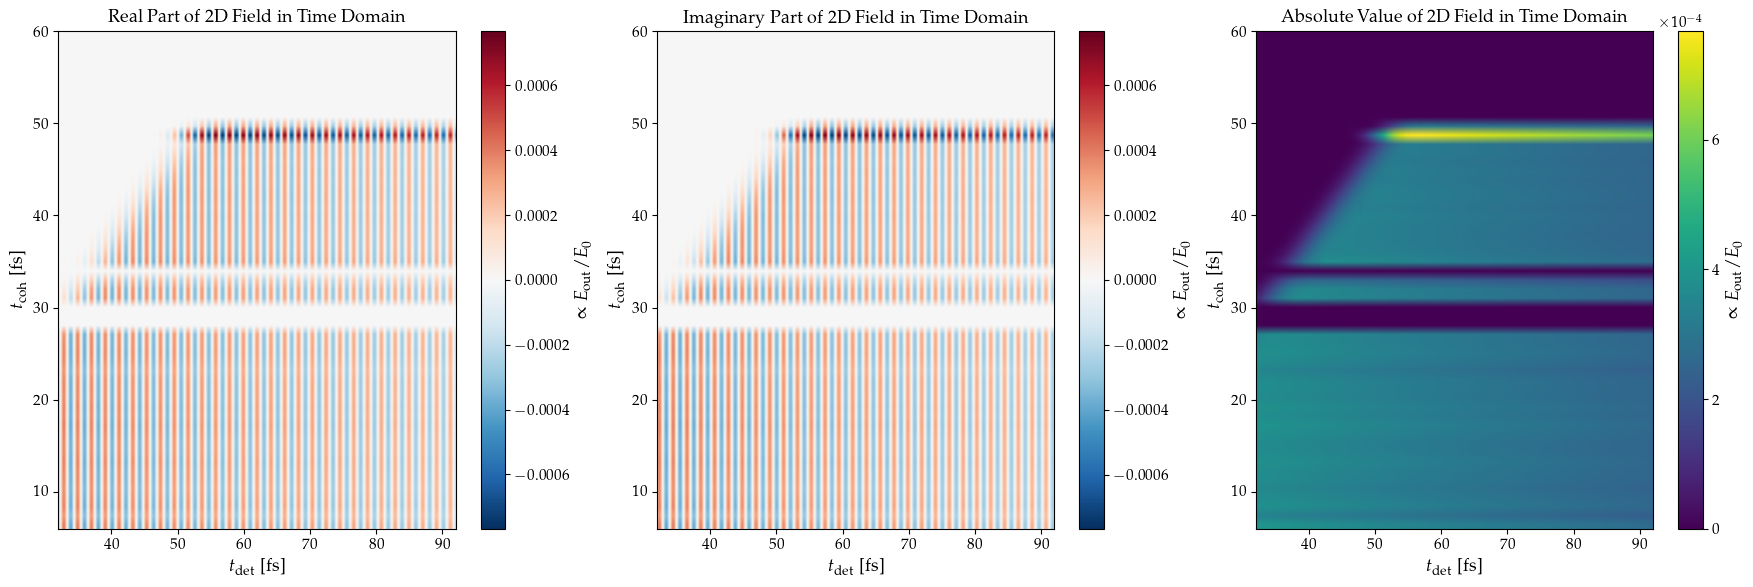

In [10]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="real",
    normalize=False,
)
axes[0].set_title(r"Real Part of 2D Field in Time Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="img",
    normalize=False,
)
axes[1].set_title(r"Imaginary Part of 2D Field in Time Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="abs",
    normalize=False,
)
axes[2].set_title(r"Absolute Value of 2D Field in Time Domain")

Text(0.5, 1.0, 'Absolute Value of 2D Field in Time Domain')

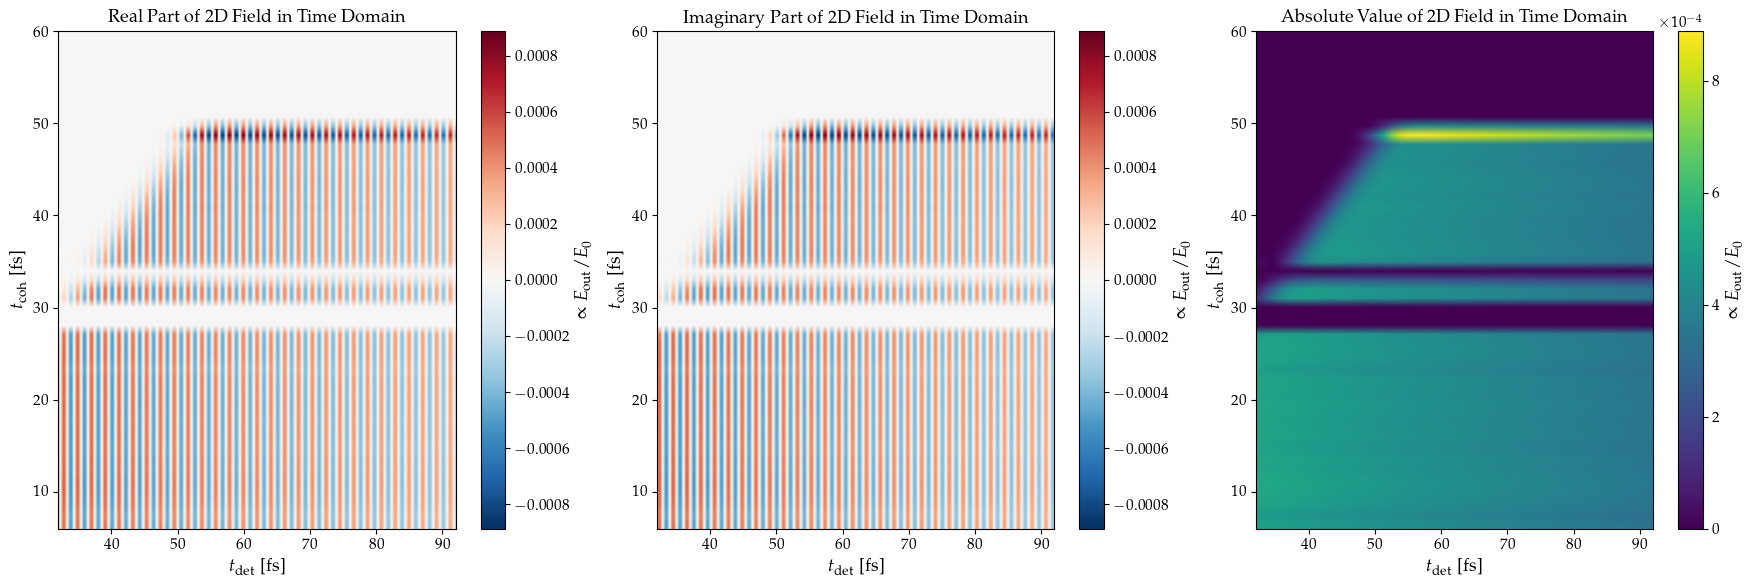

In [11]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NR,
    domain="time",
    component="real",
    normalize=False,
)
axes[0].set_title(r"Real Part of 2D Field in Time Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NR,
    domain="time",
    component="img",
    normalize=False,
)
axes[1].set_title(r"Imaginary Part of 2D Field in Time Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_NR,
    domain="time",
    component="abs",
    normalize=False,
)
axes[2].set_title(r"Absolute Value of 2D Field in Time Domain")

In [12]:
from typing import List
def compute_2d_fft_wavenumber(
    t_dets: np.ndarray,
    t_cohs: np.ndarray,
    datas: List[np.ndarray],
    signal_types: List[str] = ["rephasing"],
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    dt_coh = t_cohs[1] - t_cohs[0]
    dt_det = t_dets[1] - t_dets[0]
    N_coh = len(t_cohs)
    N_det = len(t_dets)

    def _validate(arr: np.ndarray, label: str):
        if arr.ndim != 2:
            raise ValueError(f"{label} must be 2D (N_t_coh, N_t_det)")
        if arr.shape != (N_coh, N_det):
            raise ValueError(f"{label} shape {arr.shape} != ({N_coh}, {N_det}) from provided axes")

    def _fft2(arr: np.ndarray, signal_type: str) -> np.ndarray:
        tmp_local = np.fft.fft(arr, axis=0)
        tmp_local = np.fft.fft(tmp_local, axis=1)
        # TODO for now just fix this
        spec = np.flip(np.flip(tmp_local, axis=0), axis=1)
        """
        if signal_type == "rephasing":  # flip coh -> +
            spec = np.flip(tmp_local, axis=0)
        elif signal_type == "nonrephasing":  # flip both -> +
            spec = np.flip(np.flip(tmp_local, axis=0), axis=1)
        elif signal_type == "average":  # no change
            spec = tmp_local
        else:
            raise ValueError(f"Internal signal_type '{signal_type}' unsupported")
        """
        return spec * (dt_coh * dt_det)

    if not datas:
        raise ValueError("'datas' must contain at least one 2D array")

    # Validate all arrays and compute individual spectra
    S_list: list[np.ndarray] = []
    for idx, (data, sig) in enumerate(zip(datas, signal_types)):
        _validate(data, f"datas[{idx}]")
        S_list.append(_fft2(data, sig))

    uniq = set(signal_types)
    if uniq == {"rephasing"} or uniq == {"average"} or uniq == {"nonrephasing"}:
        S_out = S_list[0]
    elif uniq == {"rephasing", "nonrephasing"}:
        # Find first occurrence of each component
        try:
            S_re = next(S for S, s in zip(S_list, signal_types) if s == "rephasing")
            S_nr = next(S for S, s in zip(S_list, signal_types) if s == "nonrephasing")
        except StopIteration:
            raise ValueError("Both rephasing and nonrephasing must be provided for absorptive")
        S_out = np.real((S_re + S_nr) / 2.0)
    else:
        raise ValueError(f"Unsupported combination of signal_types: {sorted(list(uniq))}")

    # Frequency axes & shift
    freq_cohs = np.fft.fftfreq(N_coh, d=dt_coh)
    freq_dets = np.fft.fftfreq(N_det, d=dt_det)
    S_out = np.fft.fftshift(S_out, axes=(0, 1))
    freq_cohs = np.fft.fftshift(freq_cohs)
    freq_dets = np.fft.fftshift(freq_dets)

    nu_cohs = freq_cohs / 2.998 * 10
    nu_dets = freq_dets / 2.998 * 10
    return nu_dets, nu_cohs, S_out


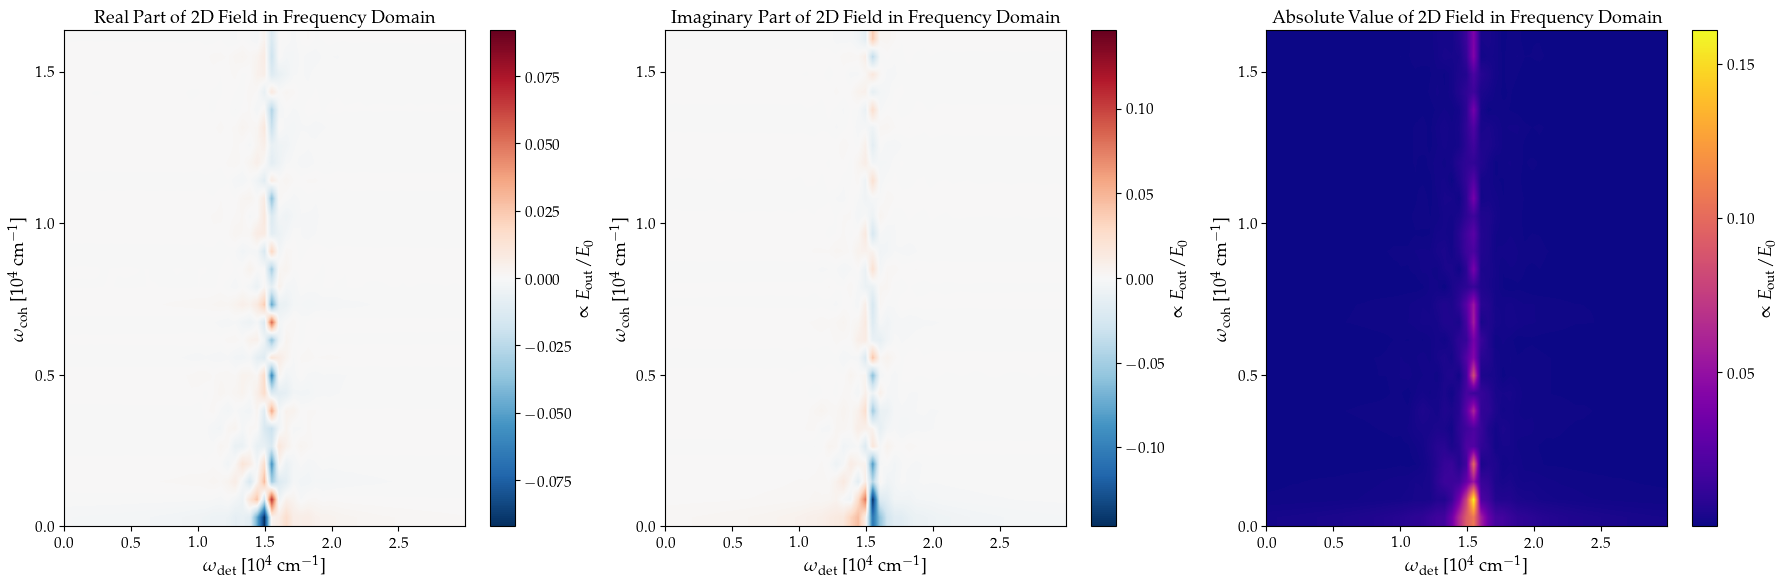

Text(0.5, 1.0, 'Absolute Value of 2D Field in Frequency Domain')

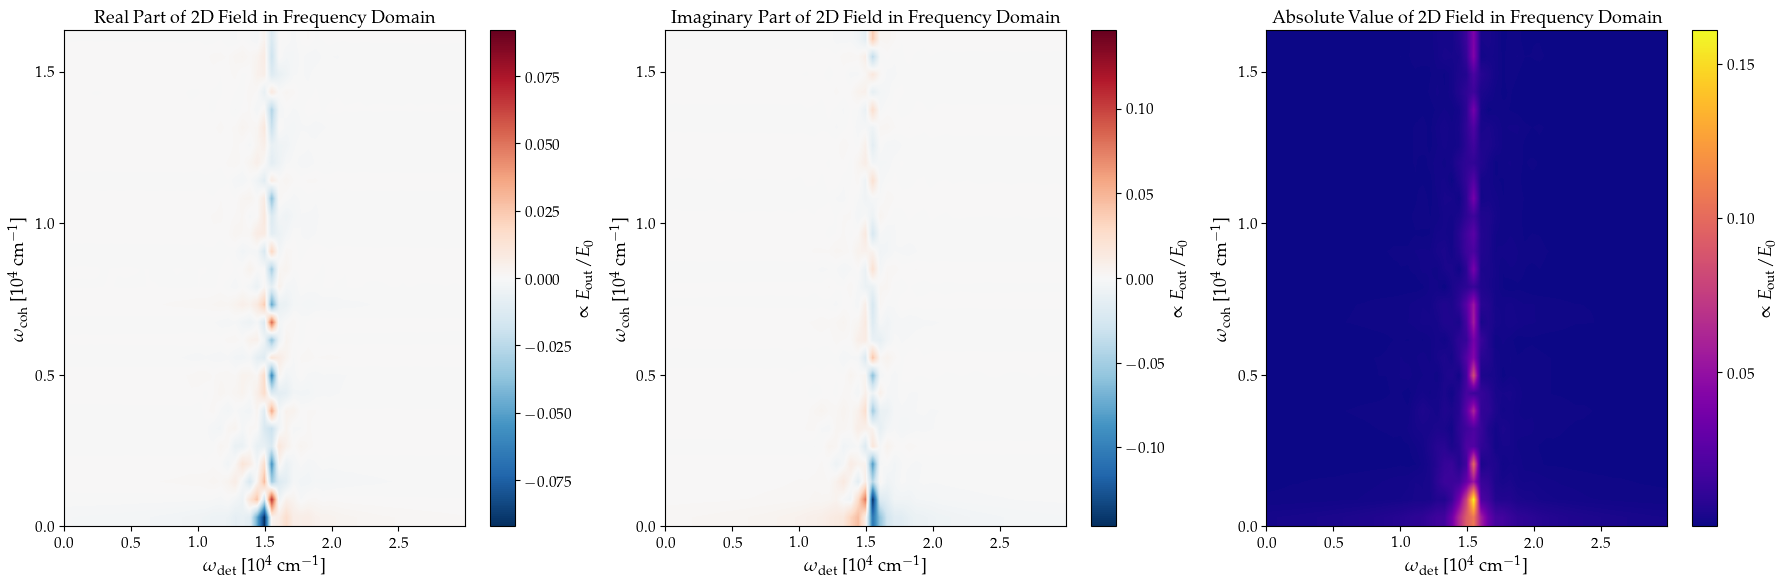

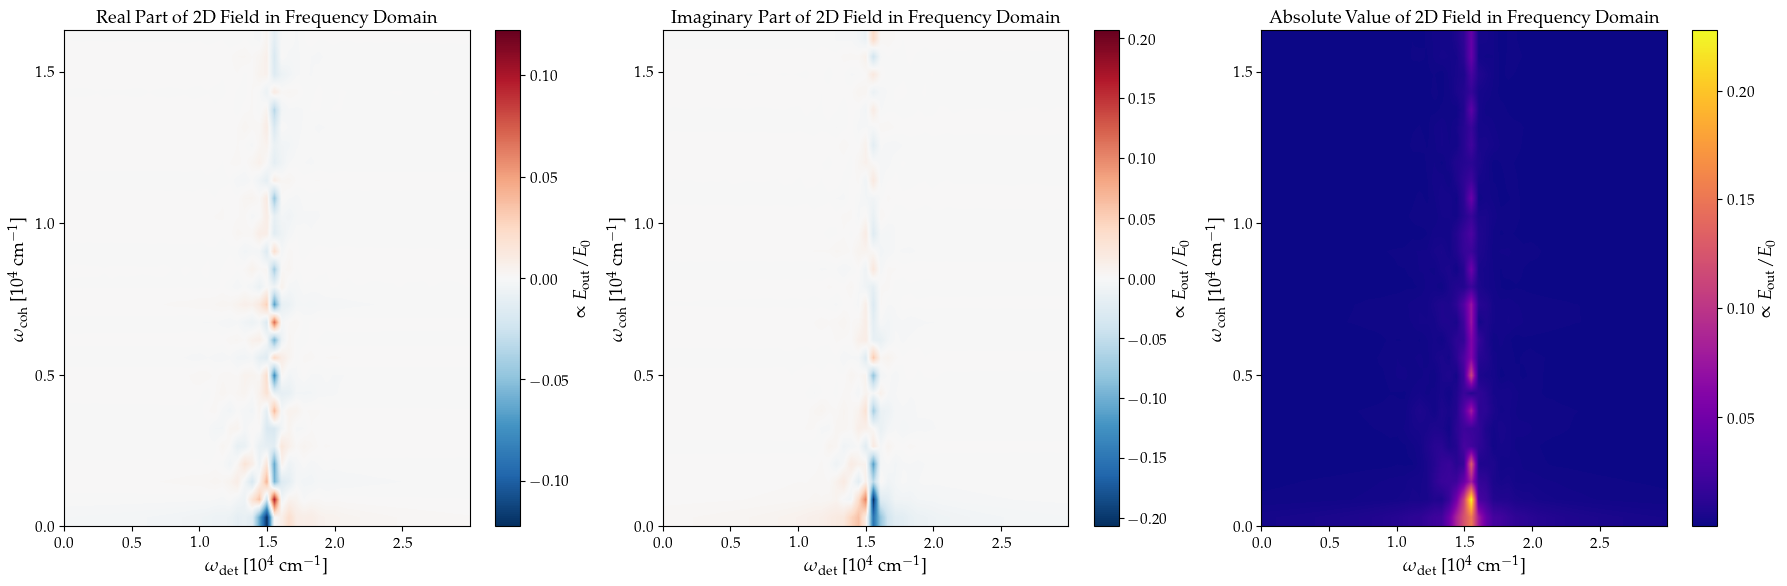

In [13]:
nu_det, nu_coh, S_2d_R = compute_2d_fft_wavenumber(
    t_actual2d, mini_t_coh, [components_2d_R], ["rephasing"])

nu_det, nu_coh, S_2d_NR = compute_2d_fft_wavenumber(
    t_actual2d, mini_t_coh, [components_2d_NR], ["nonrephasing"])

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="real",
    section=[(0, 3), (0, 3)],
    normalize=False,
)
axes[0].set_title(r"Real Part of 2D Field in Frequency Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="img",
    section=[(0, 3), (0, 3)],
    normalize=False,
)
axes[1].set_title(r"Imaginary Part of 2D Field in Frequency Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="abs",
    section=[(0, 3), (0, 3)],
    normalize=False,
)
axes[2].set_title(r"Absolute Value of 2D Field in Frequency Domain")

display(fig)
# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_NR,
    domain="freq",
    component="real",
    section=[(0, 3), (0, 3)],
    normalize=False,
)
axes[0].set_title(r"Real Part of 2D Field in Frequency Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_NR,
    domain="freq",
    component="img",
    section=[(0, 3), (0, 3)],
    normalize=False,
)
axes[1].set_title(r"Imaginary Part of 2D Field in Frequency Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_NR,
    domain="freq",
    component="abs",
    section=[(0, 3), (0, 3)],
    normalize=False,
)
axes[2].set_title(r"Absolute Value of 2D Field in Frequency Domain")

## 6. Inhomogeneous broadening (1D)

In [16]:
# Inhomogeneous broadening: Gaussian detuning ensemble on 1D polarization
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from copy import deepcopy

from qspectro2d.spectroscopy.one_d_field import parallel_compute_1d_e_comps
from qspectro2d.config.default_simulation_params import PHASE_CYCLING_PHASES, DETECTION_PHASE

# Parameters for inhomogeneous broadening
n_inhomogen         = 16
delta_inhomogen_cm  = 300.0
sim_oqs.system.update_delta_inhomogen_cm(delta_inhomogen_cm)
sim_oqs.simulation_config.n_inhomogen = n_inhomogen
# Ensure we compute only the rephasing component in this test
sim_oqs.simulation_config.signal_types = ["rephasing"]

# Detection time axis (ensure it's available in scope)
t_det      = sim_oqs.t_det
n_t        = len(t_det)

# Sample freqs from Gaussian distribution
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian

def _generate_freq_samples(sim_oqs) -> np.ndarray:
    """Return Gaussian-distributed (or deterministic) frequency samples.
    Shape: (n_inhomogen, n_atoms).
    """
    n_samples  = int(sim_oqs.simulation_config.n_inhomogen)
    base_freqs = np.asarray(sim_oqs.system.frequencies_cm, dtype=float)
    fwhm_cm    = float(sim_oqs.system.delta_inhomogen_cm)
    if n_samples <= 0:
        return np.empty((0, base_freqs.size), dtype=float)
    if np.isclose(fwhm_cm, 0.0):
        return np.tile(base_freqs, (n_samples, 1))
    samples = sample_from_gaussian(n_samples, fwhm_cm, base_freqs)
    return np.atleast_2d(samples)

samples = _generate_freq_samples(sim_oqs)  # shape (n_inhomogen, n_atoms)

# Helper (sequential) fallback if parallel_compute_1d_e_comps fails (e.g., pickling on Windows)
from qspectro2d.spectroscopy.one_d_field import (
    compute_polarization_over_window, sim_with_only_pulses, phase_cycle_component
)

def _compute_rephasing_component_sequential(sim_local) -> np.ndarray:
    phases = PHASE_CYCLING_PHASES[: sim_local.simulation_config.n_phases]
    t_window = sim_local.t_det_actual
    P_grid = np.zeros((len(phases), len(phases), len(t_window)), dtype=np.complex128)
    for i, phi1 in enumerate(phases):
        for j, phi2 in enumerate(phases):
            sim_w = deepcopy(sim_local)
            sim_w.laser.pulse_phases = [phi1, phi2]
            # Total
            _, P_total = compute_polarization_over_window(sim_w, t_window)
            # Linear sum
            P_lin = np.zeros_like(P_total)
            for p_idx in range(len(sim_w.laser.pulses)):
                sim_i = sim_with_only_pulses(sim_w, [p_idx])
                _, P_i = compute_polarization_over_window(sim_i, t_window)
                P_lin += P_i
            P_grid[i, j, :] = P_total - P_lin
    P_re = phase_cycle_component(phases, P_grid, lmn=(-1, 1, 1), phi_det=DETECTION_PHASE, normalize=True)
    return 1j * P_re  # E ~ iP

# Compute base (no detuning shift) and ensemble-averaged E-field component (rephasing)
orig_freqs_cm = sim_oqs.system.frequencies_cm.copy()

# Base
try:
    P_base = parallel_compute_1d_e_comps(sim_oqs)[0]
except Exception as ex:
    print("parallel_compute_1d_e_comps failed for base; using sequential fallback:", ex)
    P_base = _compute_rephasing_component_sequential(sim_oqs)

# Ensemble over inhomogeneous samples
n_real    = samples.shape[0]
ensemble = np.zeros((n_real, n_t), dtype=np.complex128)

for k in range(n_real):
    new_freqs = samples[k, :].tolist()
    sim_oqs.system.update_frequencies_cm(new_freqs)
    try:
        E_comp = parallel_compute_1d_e_comps(sim_oqs)[0]
    except Exception as ex:
        # Fallback per-sample
        E_comp = _compute_rephasing_component_sequential(sim_oqs)
    ensemble[k, :] = E_comp

# Average and restore base frequencies
P_avg = np.mean(ensemble, axis=0)
sim_oqs.system.update_frequencies_cm(orig_freqs_cm)

# Simple diagnostics
print(f"Inhomogeneous samples: n_real={n_real}, n_atoms={samples.shape[1]}")
print(f"Shapes -> t_det: {t_det.shape}, base: {P_base.shape}, avg: {P_avg.shape}, ensemble: {ensemble.shape}")

Inhomogeneous samples: n_real=16, n_atoms=1
Shapes -> t_det: (601,), base: (601,), avg: (601,), ensemble: (16, 601)


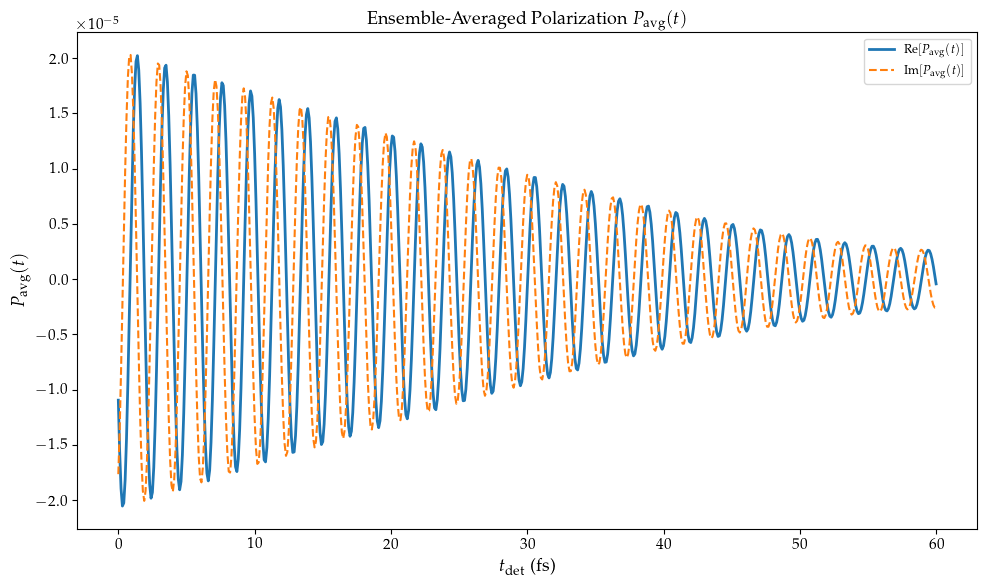

In [17]:
import matplotlib.pyplot as plt

# Plot ensemble-averaged polarization P_avg vs t_det
fig, ax = plt.subplots(figsize=(10, 6))

# Plot real part
ax.plot(t_det, np.real(P_avg), color=COLORS[0], linewidth=2.0, label=r"$\mathrm{Re}[P_{\text{avg}}(t)]$")

# Plot imaginary part
ax.plot(t_det, np.imag(P_avg), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"$\mathrm{Im}[P_{\text{avg}}(t)]$")

ax.set_xlabel(r'$t_{\text{det}}$ (fs)')
ax.set_ylabel(r'$P_{\text{avg}}(t)$')
ax.set_title(r'Ensemble-Averaged Polarization $P_{\text{avg}}(t)$')
ax.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()